In [1]:
library("tidyverse")
library("data.table")
library("cowplot")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose



Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp




In [3]:
set.seed(1)
df <- fread("/nfs/research/birney/users/saul/nextflow/medaka_behaviour_pilot/hmm/time_step0.08_n_states15_hmm.csv.gz")
df[, mean_dist := log10(mean(distance)), by = hmm_state]
tmp <- df[, .(hmm_state, mean_dist)] |> distinct() |> as.data.table()
tmp[, hmm_state_recoded := rank(mean_dist)]
df <- merge(df, tmp, by = c("hmm_state", "mean_dist"))
plt_df <- df[sample(1:.N, 10000)]

In [4]:
annot_df <- data.table(
    hmm_state_recoded = 1,
    distance = 1,
    angle = c(0, 90, -90, 180),
    label = c("0", "90", "-90", "±180")
)
annot_df

hmm_state_recoded,distance,angle,label
<dbl>,<dbl>,<dbl>,<chr>
1,1,0,0
1,1,90,90
1,1,-90,-90
1,1,180,±180


In [96]:
p1 <- ggplot() +
    geom_label(data = annot_df, aes(x = angle, y = distance, label = label), size = 5, label.size = NA) +
    geom_point(data = plt_df, aes(x = angle/pi*180, y = log10(distance)), size = 0.1) +
    coord_polar(start = pi) +
    scale_x_continuous(
        labels = c(),
        breaks = c(-90, 0, 90, 179.999) # cannot plot exactly 180
    ) +
    facet_wrap(~ hmm_state_recoded, nrow = 2, labeller = as_labeller(function(i){sprintf("HMM state %s", i)})) +
    labs(x = "Angle (deg)", y = bquote(Distance~(Log[10](px)))) +
    theme_linedraw(18) +
    theme(
        legend.position = "none",
        panel.background = element_rect(fill = "white"),
        strip.background = element_blank(),
        strip.text = element_text(color = "black"),
        panel.grid.major = element_line(color = "gray30")
    )

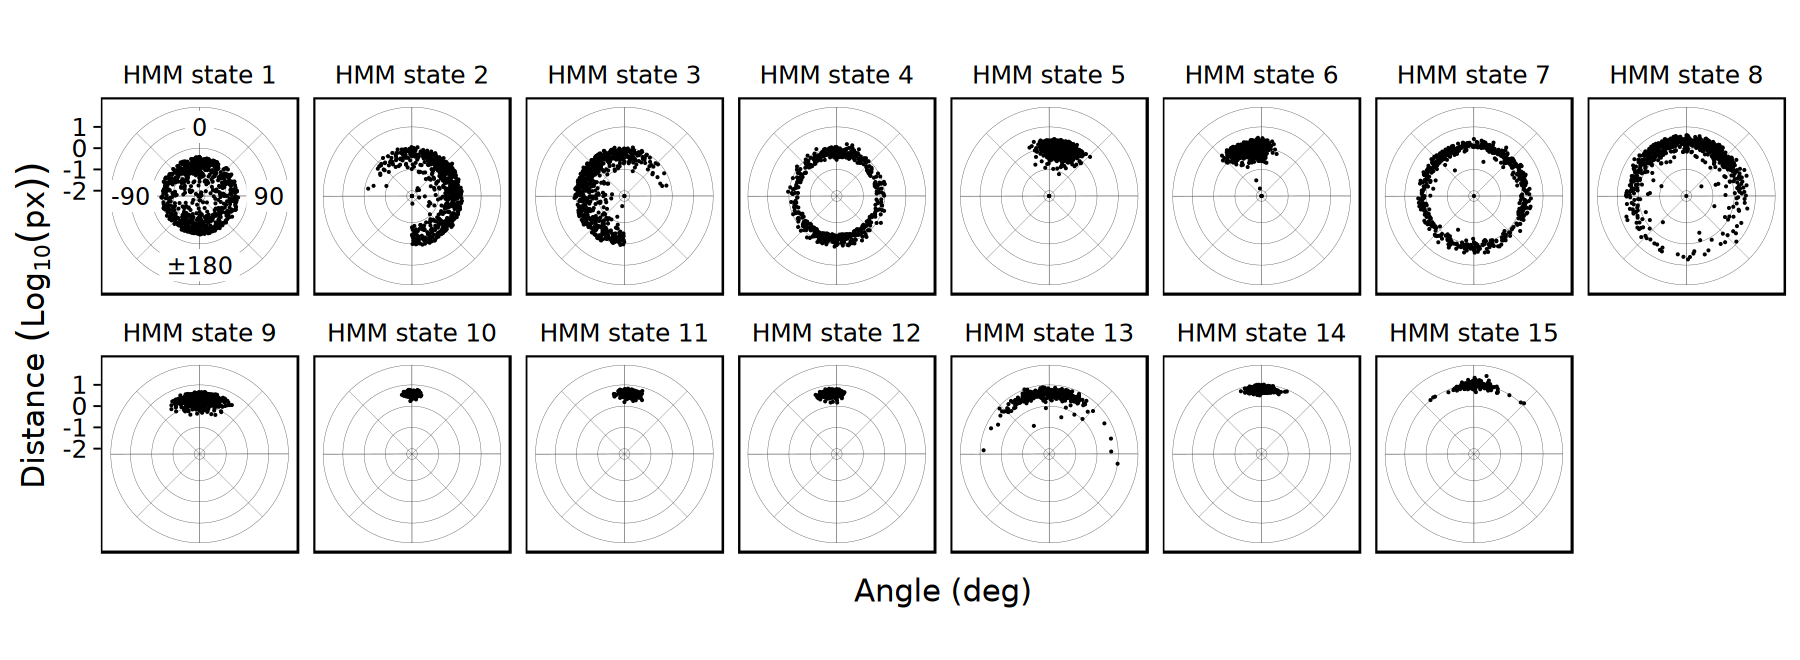

In [97]:
options(repr.plot.width = 15, repr.plot.height = 5.5)
p1

In [ ]:
f_list <- list.files("/nfs/research/birney/users/saul/nextflow/medaka_behaviour_pilot/trajectories_csv/", full.names = TRUE)
df_positions <- lapply(f_list, function(f){fread(f)[, id := basename(f) |> str_remove("_traj_with_identities.csv.gz")]}) |> rbindlist(use.names = TRUE)
df_positions[, is_ref_ref := grepl("icab_icab", id)]
df_positions[, frame_n := 1:.N, by = id]
df_positions <- melt(
    df_positions[, .(id, frame_n, ref_x, ref_y, test_x, test_y)],
    id.vars = c("id", "frame_n")
)[
    , .(
        id,
        frame_n,
        axis = str_remove(variable, "^.*_"),
        fish_type = str_remove(variable, "_.*$"),
        value
    )
]
df_positions <- dcast(df_positions, id + frame_n + fish_type ~ axis, measure.var = "value")
df_positions <- df_positions |>
    separate(
        id,
        into = c("date", "time_string", "ref_strain", "test_strain", "tank_side", "assay", "quadrant"),
        sep = "_",
        remove = FALSE
    ) |>
    as.data.table()
df_positions[, id := sprintf("%s_%s", id, fish_type)]
head(df_positions)

In [22]:
df_merged <- merge(df, df_positions, by = c("id", "frame_n"), all.x = TRUE)
head(df_merged)

id,frame_n,hmm_state,mean_dist,time_s,distance,angle,hmm_state_recoded,date,time_string,ref_strain,test_strain,tank_side,assay,quadrant,fish_type,x,y
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
20190611_1331_icab_icab_R_no_q1_ref,3,11,-0.1871935,0.1000000,0.83681897,2.993237,4,20190611,1331,icab,icab,R,no,q1,ref,227.1498,68.52848
20190611_1331_icab_icab_R_no_q1_ref,5,11,-0.1871935,0.1666667,0.37884199,2.356685,4,20190611,1331,icab,icab,R,no,q1,ref,226.9091,68.23593
20190611_1331_icab_icab_R_no_q1_ref,7,14,-0.8060102,0.2333333,0.31815616,2.949842,1,20190611,1331,icab,icab,R,no,q1,ref,227.2257,68.26688
20190611_1331_icab_icab_R_no_q1_ref,9,14,-0.8060102,0.3000000,0.02669565,0.401145,1,20190611,1331,icab,icab,R,no,q1,ref,227.1992,68.26939
20190611_1331_icab_icab_R_no_q1_ref,11,14,-0.8060102,0.3666667,0.07495629,1.065193,1,20190611,1331,icab,icab,R,no,q1,ref,227.1277,68.24675
20190611_1331_icab_icab_R_no_q1_ref,13,14,-0.8060102,0.4333333,0.10567185,-3.103933,1,20190611,1331,icab,icab,R,no,q1,ref,227.1068,68.14316


In [28]:
nrow(df) == nrow(df_merged)
df_merged[is.na(x) | is.na(y), .N]

[1] TRUE

[1] 0

In [108]:
p2 <- ggplot(df_merged, aes(x = x, y = y)) +
    stat_density_2d(aes(fill = after_stat(density)), geom = "raster", contour = FALSE) +
    scale_x_continuous(expand = expansion(mult = c(0, 0))) +
    scale_y_reverse(expand = expansion(mult = c(0, 0))) + # y is up to down
    scale_fill_distiller(palette = "RdBu", labels = scales::label_scientific(digits = 2)) +
    facet_wrap(~ hmm_state_recoded, nrow = 2, labeller = as_labeller(function(i){sprintf("HMM state %s", i)})) +
    labs(y = "Position y (px)", x = "Position x (px)", fill = "Density     ") +
    theme_cowplot(18) +
    theme(
        axis.line = element_blank(),
        strip.background = element_blank(),
        panel.background = element_rect(fill = "gray"),
        axis.title.x = element_text(margin = margin(t = 4)),
        axis.title.y = element_text(margin = margin(r = 10)),
        axis.text = element_text(size = 9),
        legend.position = "bottom",
        legend.key.width = unit(2, "in")
    )

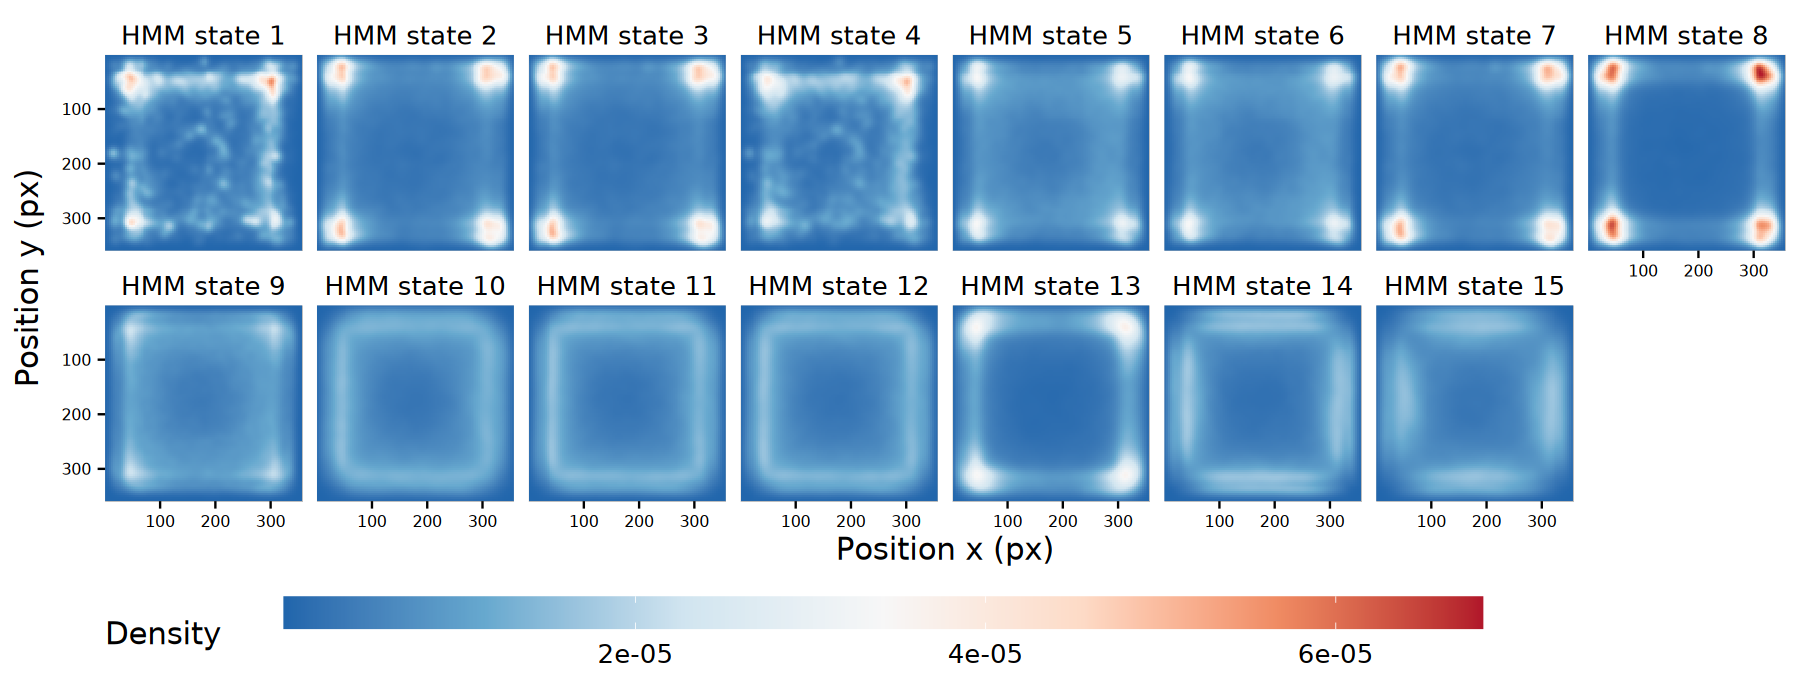

In [109]:
options(repr.plot.width = 15, repr.plot.height = 5.7)
p2

In [110]:
p <- plot_grid(p1, p2, nrow = 2, align = "vertical", axis = "lr")

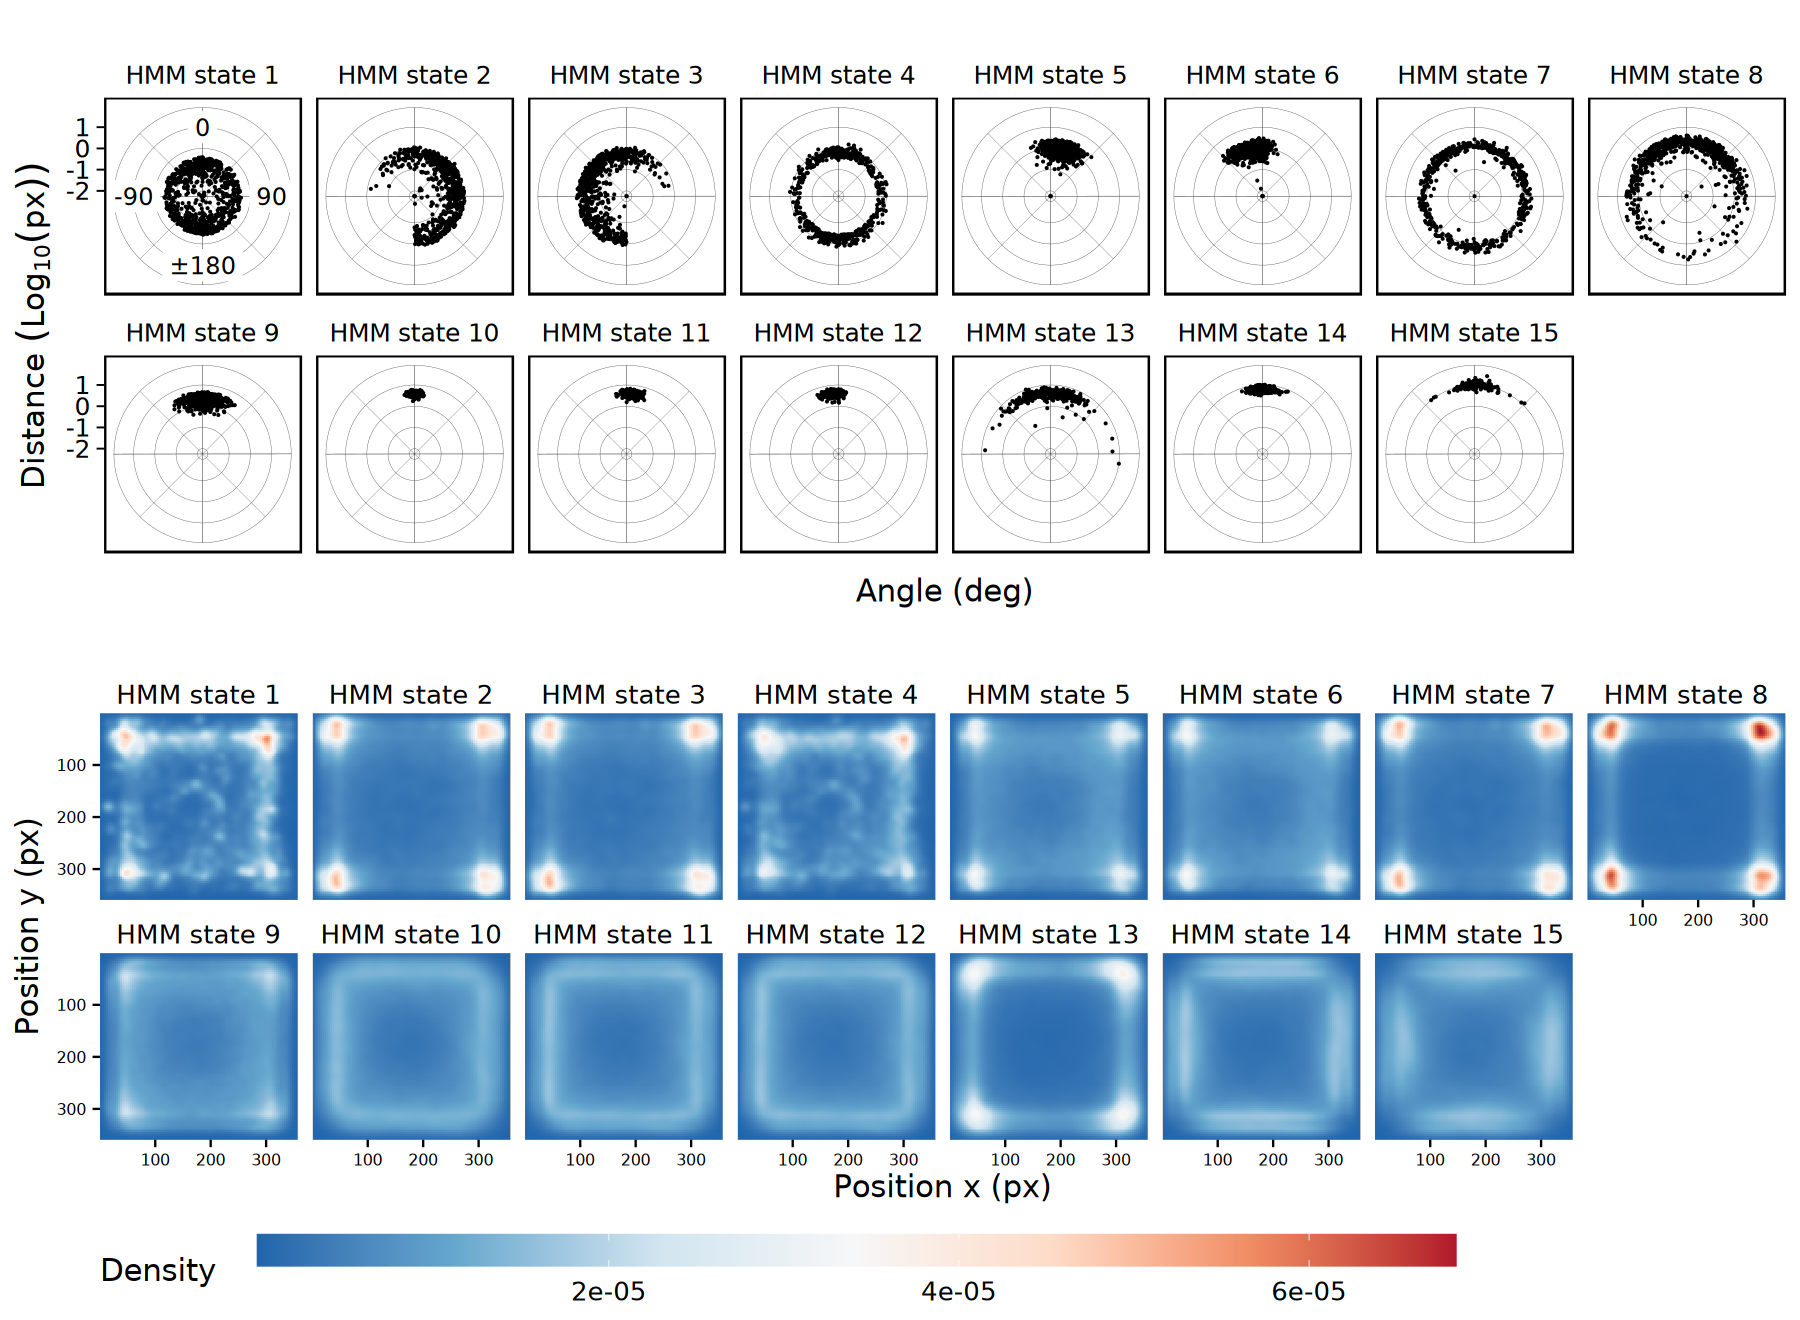

In [111]:
options(repr.plot.width = 15, repr.plot.height = 11)
p

In [112]:
ggsave(
    "fig4.pdf",
    p,
    width = 15,
    height = 11
)